In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time 
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import MinMaxScaler

## Data Cleaning

In [2]:
rawData = pd.read_csv('data/SqlMetric_prepared.csv')
rawData.head()

,Event Name,Time MSec,Process Name,criteria,DURATION_MSEC,metrics,timestamp,usn,viewName,ActivityID
0,UIServerEventSource/LoadDataStart/Start,2518.457,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
1,UIServerEventSource/LoadDataStop/Stop,2621.028,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
2,UIServerEventSource/LoadDataStart/Start,2621.106,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
3,UIServerEventSource/LoadDataStop/Stop,2700.351,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
4,UIServerEventSource/LoadDataStart/Start,2700.375,Process(2920) (2920),Key,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2,NaN


In [3]:
rawData.drop(['ActivityID', 'Event Name', 'criteria', 'Process Name'], axis=1, inplace=True)

In [4]:
rawData.isnull().sum()

Time MSec             0
DURATION_MSEC    173975
metrics               0
timestamp             0
usn                   0
viewName              0
dtype: int64

In [5]:
rawData.dropna(inplace=True)
print(rawData.isnull().sum())
print('Dataset shape: {}'.format(rawData.shape))

Time MSec        0
DURATION_MSEC    0
metrics          0
timestamp        0
usn              0
viewName         0
dtype: int64
Dataset shape: (173974, 6)


In [6]:
rawData.head()

,Time MSec,DURATION_MSEC,metrics,timestamp,usn,viewName
1,2621.028,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0
3,2700.351,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1
5,2701.448,1.073,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2
7,6288.764,"3,587.28",Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_3
9,6386.315,97.403,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,"76,986",Procedure_4


In [7]:
rawData['db_state'] = rawData['metrics'].apply(lambda x: x.split(' '))
rawData.drop(['metrics'], axis=1, inplace=True)
print('Dataset shape: {}'.format(rawData.shape))
row = rawData.iloc[0,5]
print('Metrics: {}'.format(row))

dic = {}

for st in row:
    splitted = st.split(':')
    key = splitted[0] 
    dic[key] = [] 
    
print('Parsing sql metrics')
for index, row in rawData.iterrows():
    metrics_row = row['db_state']
    for i in range(0,4):
        st = metrics_row[i]
        splitted = st.split(':')
        key = 'Table_{}'.format(i+1)
        val = np.NaN   
        if len(splitted)>1:
            val = int(splitted[1])
        
        dic[key].append(val)
        

print('Adding new metrics collumns')     
for key in dic.keys():
    rawData[key] = dic[key]

print('Drop db_state column')
rawData.drop(['db_state'], axis=1, inplace=True)
    
print('Parsing sql metrics finnised')
print('Dataset shape: {}'.format(rawData.shape))

Dataset shape: (173974, 6)
Metrics: ['Table_1:47', 'Table_2:476', 'Table_3:199', 'Table_4:56']
Parsing sql metrics
Adding new metrics collumns
Drop db_state column
Parsing sql metrics finnised
Dataset shape: (173974, 9)


In [8]:
print(rawData.isnull().sum())

Time MSec           0
DURATION_MSEC       0
timestamp           0
usn                 0
viewName            0
Table_1          4844
Table_2          4844
Table_3          4844
Table_4          4844
dtype: int64


In [9]:
rawData.dropna(inplace=True)
print('Dataset shape: {}'.format(rawData.shape))

Dataset shape: (169130, 9)


In [10]:
rawData = rawData.applymap(lambda x: x.replace(',','') if type(x) is str or type(x) is object else x)
rawData['is_cold_start'] = rawData['usn'].apply(lambda x: True if int(x) == 0 else False)
rawData.drop(['usn', 'timestamp'], axis=1, inplace=True)
rawData.rename(columns={'Time MSec': 'timestamp', 'DURATION_MSEC': 'duration'}, inplace=True)
rawData['duration'] = rawData['duration'].apply(lambda x: float(x))
rawData.loc[:, 'second'] = rawData.loc[:, 'timestamp'].apply(lambda x: round(x/1000))
print(rawData.isnull().sum())
rawData.head()

timestamp        0
duration         0
viewName         0
Table_1          0
Table_2          0
Table_3          0
Table_4          0
is_cold_start    0
second           0
dtype: int64


,timestamp,duration,viewName,Table_1,Table_2,Table_3,Table_4,is_cold_start,second
1,2621.028,102.572,Procedure_0,47.0,476.0,199.0,56.0,True,3
3,2700.351,79.245,Procedure_1,47.0,476.0,199.0,56.0,True,3
5,2701.448,1.073,Procedure_2,47.0,476.0,199.0,56.0,True,3
7,6288.764,3587.280,Procedure_3,47.0,476.0,199.0,56.0,True,6
9,6386.315,97.403,Procedure_4,47.0,476.0,199.0,56.0,False,6


In [11]:
rawData.shape

(169130, 9)

## Studing data

Decalre some helpers

In [55]:
main_color = '#2a6e52'
accent_color = '#6e4b2a'
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] = '#fff'
plt.rcParams["axes.edgecolor"] = '#222'
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.color"] = main_color

def get_top_calling_procedures(df_procedures, limit):
    top = df_procedures.groupby('viewName')['viewName'].count().sort_values(ascending=False)
    return df_procedures.loc[df_procedures['viewName'].isin(top[top>= 1000].keys())]

def calculate_std(data):
    procedure_names = df['viewName'].unique()
    for p in procedure_names:
        proc = df.loc[df['viewName']== p]
        median = proc['duaration'].median()

def draw_dependency_plot(df, tables):
    procedure_names = df['viewName'].unique()
    proc_num = range(len(procedure_names))
    table_count = len(tables)
    proc_count = len(proc_num)
    rowsCount =  table_count + proc_count

    fig, ax = plt.subplots(rowsCount,1,figsize=(20,rowsCount*5))
    current_row = 0
    for p in procedure_names:
        proc = df.loc[df['viewName']== p]
        x =  proc['second'].unique()
        y =  proc[['duration','second']].groupby('second').mean()
        ax[current_row].set_title(p)
        ax[current_row].plot(x,y, color = main_color)
        ax[current_row].set_xlabel('Time (s)')
        ax[current_row].set_ylabel('Duration (ms)')
        ax[current_row].grid(True)
        current_row+= 1
    
    for table in tables:
        df_table = df.loc[:,[table, 'second']]
        x2 =  df_table['second'].unique()
        y2 = df_table.groupby('second').max()   
        ax[current_row].set_title(table)
        ax[current_row].plot(x2,y2, color= accent_color)
        ax[current_row].set_xlabel('Time (s)')
        ax[current_row].set_ylabel('Table Count')
        current_row+=1
    
    plt.show()

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3

def clusterize(data):
    start_time = time.time()
    seed = 0
    X_train = data
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    sz = X_train.shape[1]
    ks = KShape(n_clusters=3, verbose=True, random_state=seed)
    y_pred = ks.fit_predict(X_train)

    plt.figure()
    for yi in range(3):
        plt.subplot(3, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    

    print('Clustering completed in {:,.2f} secs'.format(time.time()-start_time))

Look at data stats

In [13]:
rawData.describe()

,timestamp,duration,Table_1,Table_2,Table_3,Table_4,second
count,1.691300e+05,169130.000000,169130.0,169130.000000,169130.000000,169130.0,169130.000000
mean,7.477735e+07,193.602204,47.0,2575.708585,543.799947,56.0,74777.346065
std,4.097056e+07,1734.437014,0.0,938.529156,85.067045,0.0,40970.560275
min,2.621028e+03,0.561000,47.0,476.000000,196.000000,56.0,3.000000
25%,4.076446e+07,10.921000,47.0,1917.000000,555.000000,56.0,40764.000000
50%,7.403702e+07,64.465000,47.0,2664.000000,559.000000,56.0,74037.000000
75%,1.100676e+08,121.580250,47.0,3360.000000,595.000000,56.0,110068.000000
max,1.461257e+08,163248.610000,47.0,4075.000000,596.000000,56.0,146126.000000


Get only changing columns

In [14]:
data = rawData[['viewName','timestamp','second', 'duration', 'is_cold_start','Table_2', 'Table_3']]

In [15]:
normal_execution =  data.loc[data['is_cold_start']==False, :]
cold_execution = data.loc[data['is_cold_start']==True, :]
cold_percentage =len(cold_execution)*100/len(data)
normal_percentage = 100 - cold_percentage 
print ("Total executions {} Normal execution {}({:,.2f}% from total, Cold execution {}({:,.2f}% form total))".format(len(data), len(normal_execution),normal_percentage,len(cold_execution),cold_percentage))

Total executions 169130 Normal execution 60061(35.51% from total, Cold execution 109069(64.49% form total))


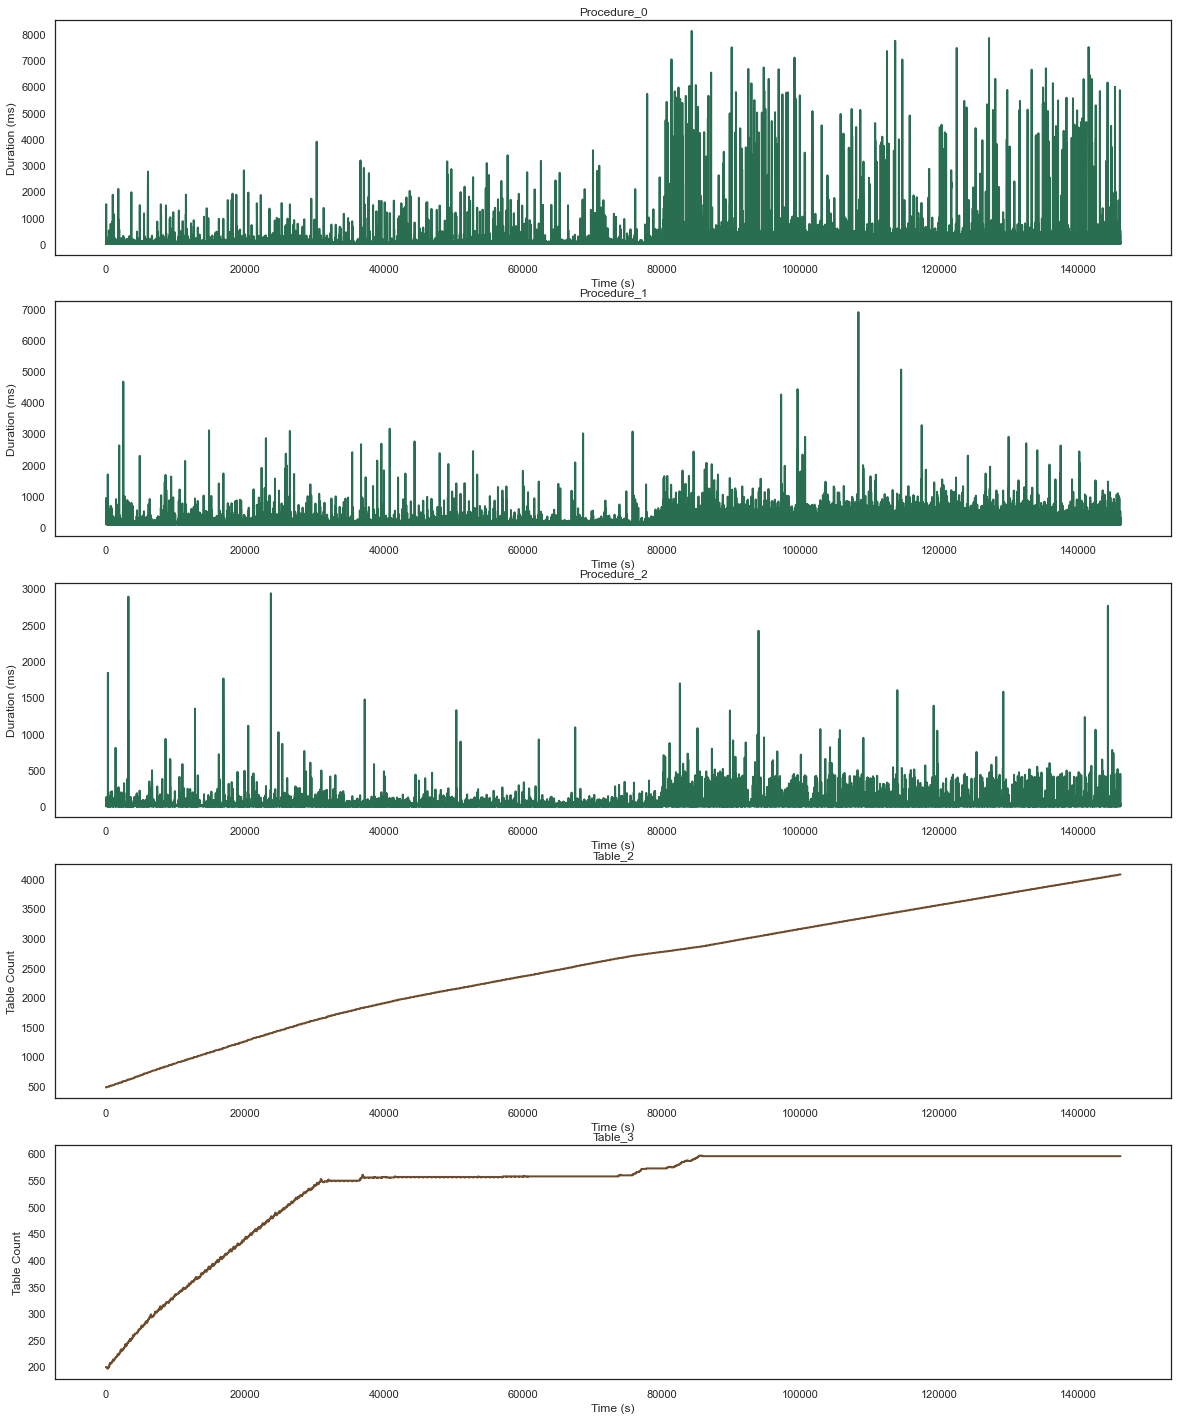

In [33]:
top_p = get_top_calling_procedures(cold_execution, 1000)
tables = ['Table_2', 'Table_3']
draw_dependency_plot(top_p, tables) 

In [17]:
top_p = get_top_calling_procedures(cold_execution, 1000)
top_frequency = top_p.loc[:,['viewName', 'timestamp', 'second']].groupby(['viewName','second']).count()
print(top_frequency.describe())

       timestamp
count   109068.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0


Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


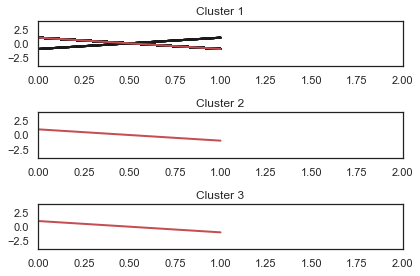

Clustering completed in 340.85 secs


In [56]:
top_p = get_top_calling_procedures(cold_execution, 1000)
parameters = top_p[['second', 'duration']].to_numpy()
clusterize(parameters)